# Pressure Decline Curve Analysis

Decline curve analysis is a graphical method for analyzing diminishing production rates and predicting future well performance. Using some basic curves, a curve fit of previous manufacturing performance is created. This information is then utilized to forecast future performance and calculate recoverable reserves. Arps (1945) claimed that a member of the hyperbolic family of equations may be used to express the "curvature" of the Production Flow rate versus time curve analytically. The Initial declin rate Di and Arps' decline-curve exponent b are two parameters that define the three types of drop-off behavior described by Arps:
- Exponential decline.

- Harmonic decline.

- Hyperbolic decline.

In [1]:
#importing necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import missingno
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv(r'C:\Users\Dursun\OneDrive - Baku Higher Oil School\Desktop\norne_production_rate_sample.csv')
df.tail(5)

,Date,Rate (SCF/d)
59,2006-11-01,289382.91
60,2006-11-09,293290.66
61,2006-11-11,293359.31
62,2006-11-17,351398.16
63,2006-12-01,351398.16


**The assignment done more in the form of research/methods for DCA and Data Analysis. But if you want to use it for your own data, you can give the path to .csv file that have same structure (Column types and names)**

*Norne Field in the North Sea production data was used to create this sample. The sample comes from a single well that produced gas between 2004 and 2006. Let's check some descriptive stats about production*



In [3]:
df.describe()

,Rate (SCF/d)
count,6.400000e+01
mean,6.222091e+05
std,5.984297e+05
min,0.000000e+00
25%,3.045196e+05
50%,3.878540e+05
75%,6.235037e+05
max,2.706039e+06


In [4]:
df.isnull().sum()

Date            0
Rate (SCF/d)    0
dtype: int64

Cool, we do not have any values. Let's check datatypes:

In [5]:
df.dtypes

Date             object
Rate (SCF/d)    float64
dtype: object

'Date' column is not in correct format

In [6]:
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.rename({'Rate (SCF/d)':'Rate_scf_d'},axis = 1, inplace = True)


In [7]:
t = df['Date']
q = df['Rate_scf_d']

import datetime


# subtract one datetime to another datetime
timedelta = [j-i for i, j in zip(t[:-1], t[1:])]
timedelta = np.array(timedelta)
timedelta = timedelta / datetime.timedelta(days=1)


# take cumulative sum over timedeltas
t = np.cumsum(timedelta)
t = np.append(0, t)
t = t.astype(float)

In [8]:
t_normalized = t / max(t)
q_normalized = q / max(q)

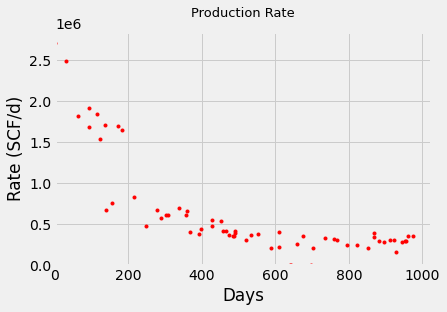

In [9]:
plt.plot(t, q, '.', color='red')
plt.title('Production Rate', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (SCF/d)')
plt.xlim(xmin=0); plt.ylim(ymin=0)


plt.show()

# Theory

**Arps Production Decline Equation Summary**

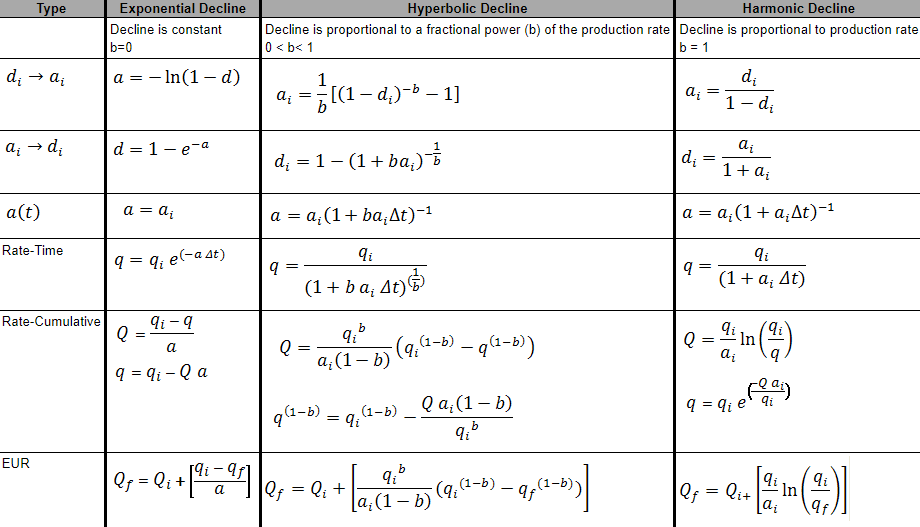

### In simple terms, general decline function can be described by the equation: 

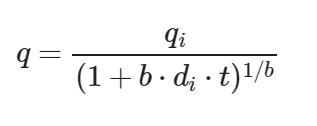

Let's write the function for it:

In [10]:
# function for hyperbolic decline
def hyperbolic(t, qi, di, b):
  return qi / (np.abs((1 + b * di * t))**(1/b))


# fitting the data with the hyperbolic function
from scipy.optimize import curve_fit


popt, pcov = curve_fit(hyperbolic, t_normalized, q_normalized)

Let's normalize our data:

In [11]:
qi, di, b = popt


# de-normalize qi and di
qi = qi * max(q)
di = di / max(t)


print('Initial production rate:', np.round(qi, 3), 'MMSCF')
print('Initial decline rate:', np.round(di, 3), 'SCF/D')
print('Decline coefficient:', np.round(b, 3))

Initial production rate: 2866266.471 MMSCF
Initial decline rate: 0.007 SCF/D
Decline coefficient: 0.5


In [12]:
def cumpro(q_forecast, qi, di, b):
  return (((qi**b) / ((1 - b) * di)) * ((qi ** (1 - b)) - (q_forecast ** (1 - b))))  

In [13]:
t_forecast = np.arange(1501)
q_forecast = hyperbolic(t_forecast, qi, di, b)


# forecast cumulative production until 1,500 days
Qp_forecast = cumpro(q_forecast, qi, di, b)

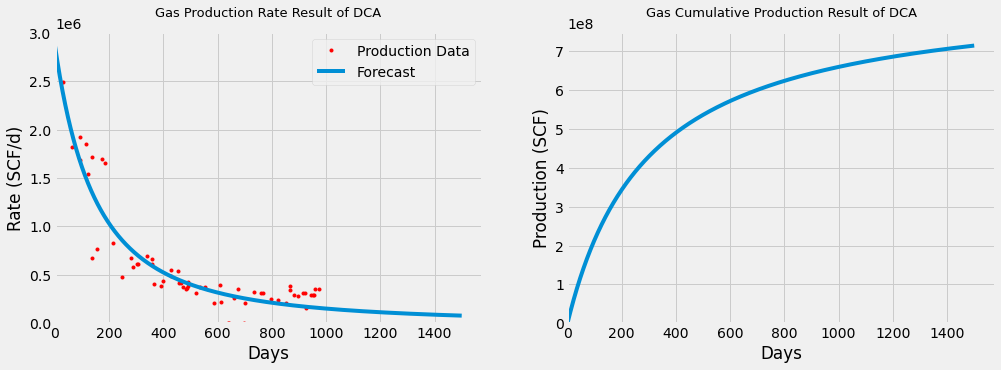

In [14]:
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
plt.plot(t, q, '.', color='red', label='Production Data')
plt.plot(t_forecast, q_forecast, label='Forecast')
plt.title('Gas Production Rate Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (SCF/d)')
plt.xlim(xmin=0); plt.ylim(ymin=0)
plt.legend()


plt.subplot(1,2,2)
plt.plot(t_forecast, Qp_forecast)
plt.title('Gas Cumulative Production Result of DCA', size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Production (SCF)')
plt.xlim(xmin=0); plt.ylim(ymin=0)


plt.show()

**Extrapolating hyperbolic declines over longer time periods typically yields unrealistically high reserves. To avoid this issue, it has been suggested that the hyperbolic decline be transformed to an exponential decline at some point in the future (Robertson). But in our case, fit seems pretty good**

In [15]:
dataset = pd.DataFrame({'Rate': q_normalized, 'Time': t_normalized})
dataset.tail()

,Rate,Time
59,0.106940,0.969199
60,0.108384,0.977413
61,0.108409,0.979466
62,0.129857,0.985626
63,0.129857,1.000000


## Time-series forecasting

Although the production rates depend on many factors, I will try to predict next days' production rates using SARIMAX (Seasonal AutoRegressive Integrated Moving Average) just for curiosity.

In [16]:
df_prediction = df.copy()

In [17]:
df_prediction = df_prediction.set_index('Date')

In [18]:
import statsmodels.api as sm


In [19]:
model=sm.tsa.statespace.SARIMAX(df_prediction['Rate_scf_d'],order=(1, 1, 1),seasonal_order=(1,1,1,10))
results=model.fit()

C:\Users\Dursun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Dursun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### Our fit to the data:

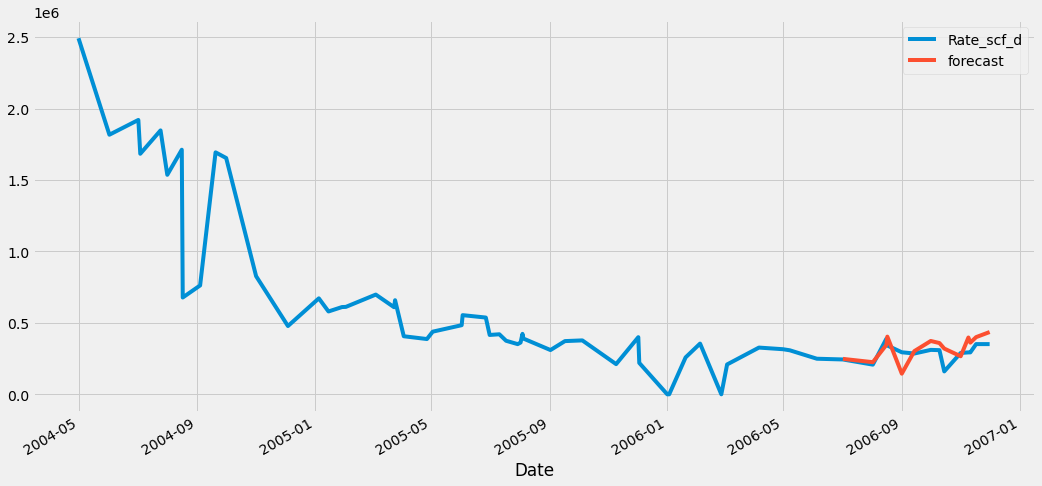

In [20]:
df_prediction['forecast']=results.predict(start=50,end=63,dynamic=True)
df_prediction[['Rate_scf_d','forecast']][1:].plot(figsize=(16,8))
plt.show()

Mean absolute error:

In [21]:
mean_absolute_error(df_prediction['Rate_scf_d'][50:],df_prediction['forecast'][50:])


63823.78003184431

Let's check how much error do we have in average:

In [22]:
mean_absolute_error(df_prediction['Rate_scf_d'][50:],df_prediction['forecast'][50:])*100/np.mean(df_prediction['Rate_scf_d'][50:])


21.68363072085399

# Prediction

After validation, now we will create future time steps and try to predict the production

In [23]:
dffuture = df_prediction.copy()
dffuture.drop('forecast', axis=1, inplace = True)
dffuture.tail(3)

,Rate_scf_d
Date,
2006-11-11,293359.31
2006-11-17,351398.16
2006-12-01,351398.16


In [24]:
future = pd.DataFrame(columns=['Rate_scf_d','Date'])

In [25]:
date = pd.date_range('12/02/2006', periods=20, freq='D')
future = future.assign(Date=date)

In [26]:
future = future.set_index('Date')

In [27]:
dffuture = dffuture.append(future)

In [28]:
model2=sm.tsa.statespace.SARIMAX(dffuture['Rate_scf_d'],order=(1, 1, 1),seasonal_order=(2,1,1,12))
results2=model2.fit()

C:\Users\Dursun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Dursun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


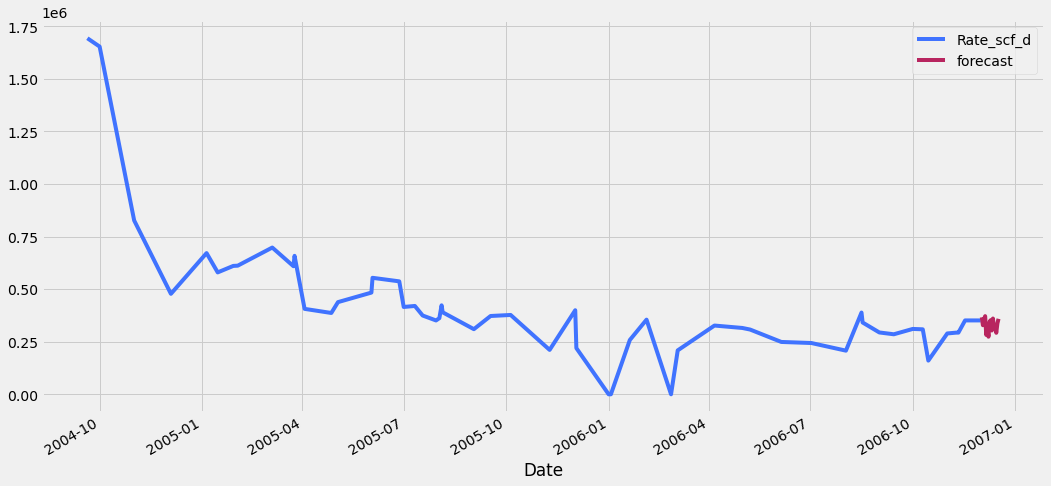

In [29]:
dffuture['forecast']=results2.predict(start=64,end=79,dynamic=True)
dffuture[['Rate_scf_d','forecast']][10:].plot.line(figsize=(16,8), color={"Rate_scf_d": "#4073FF", "forecast": "#B8255F"})
plt.show()

#### Prediction results are not exactly what we were looking for but with *more features and data span*, I am sure we can get better results.

References
1) https://trainingpython.z19.web.core.windows.net/Exercise3Solution.html
2) https://www.ihsenergy.ca/support/documentation_ca/Harmony/content/html_files/reference_material/analysis_method_theory/decline_theory.htm
3) https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
